In [59]:
# import library
import pandas as pd
import numpy as np 
import matlab 
import matplotlib.pyplot as plt
import os
import numpy as np
from gc import callbacks
import scipy.linalg as la
from sklearn import preprocessing
from distfit import distfit
from sklearn.decomposition import PCA


In [2]:
# read the file
# mortality
zipped = True
if zipped:
    mdf_path = r'data/mdf_final.csv'
    mdf = pd.read_csv(mdf_path, low_memory=False)
    mdf = mdf.drop(columns='Unnamed: 0')
    
    pdf_path = r'data\pdf_final.csv'
    pdf = pd.read_csv(pdf_path, low_memory=False)
    pdf = pdf.drop(columns=['Lb', 'Unnamed: 0'])
    
    lnmrdf = pd.read_csv(r'data/lnmr_final.csv', low_memory=False)
    lnmrdf = lnmrdf.drop(columns='Unnamed: 0')
    
    
else:
    mortality_path_7 = r'data/MortIcd7.csv'
    mortality_data_7 = pd.read_csv(mortality_path_7, low_memory=False)

    mortality_path_8 = r'data/MortIcd8.csv'
    mortality_data_8 = pd.read_csv(mortality_path_8, low_memory=False)

    mortality_path_9 = r'data/Morticd9.csv'
    mortality_data_9 = pd.read_csv(mortality_path_9, low_memory=False)

    mortality_path_2002 = r'data/Morticd10_part1.csv'
    mortality_data_2002 = pd.read_csv(mortality_path_2002, low_memory=False)

    mortality_path_2007 = r'data/Morticd10_part2.csv'
    mortality_data_2007 = pd.read_csv(mortality_path_2007, low_memory=False)

    mortality_path_2012 = r'data/Morticd10_part3.csv'
    mortality_data_2012 = pd.read_csv(mortality_path_2012, low_memory=False)

    mortality_path_2016 = r'data/Morticd10_part4.csv'
    mortality_data_2016 = pd.read_csv(mortality_path_2016, low_memory=False)

    mdf = pd.concat([mortality_data_7, mortality_data_8, mortality_data_9, mortality_data_2002, mortality_data_2007, mortality_data_2012, mortality_data_2016], ignore_index=True)
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)

    # population
    pop_path = r'data/pop.csv'
    pdf = pd.read_csv(pop_path, low_memory=False)
    dropped = False
    if not dropped:
        undesired_population_columns = ['Admin1', 'SubDiv', 'Sex', 'Frmat', 'Lb'] 
        pdf = pdf.drop(columns = undesired_population_columns)

# country code
country_code_path = r'data/country_codes.csv'
country_code = pd.read_csv(country_code_path, low_memory=False)
# creating the country code map 
country_code_map = {}
for index, rows in country_code.iterrows():
    country_code_map[rows['country']] = rows['name']

In [3]:
# needs to swap out the nah columns into averages 
done = True
if not done:
    not_used_country_list = []
    country_num_count = 0
    not_useful = False
    for key in country_code_map:
        country_num_count += 1
        display(country_num_count / len(country_code_map))
        country_mdf = mdf[mdf['Country'] == key]
        
        if country_mdf.empty:
            not_used_country_list.append(key)
        
        else:
            min_year = int(country_mdf['Year'].min())
            max_year = int(country_mdf['Year'].max()) 
            for i in range (min_year, max_year + 1):
                
                if not_useful:
                    break
                
                mask = (mdf['Country'] == key) & (mdf['Year'] == i)
                curr_Year = i

                for c in mdf.columns.values:
                    
                    if not_useful:
                        break
                    
                    average = mdf.loc[mask, c].mean()   
                    
                    max_iter = max_year - curr_Year
                    count = 0 
                    while np.isnan(average):
                        curr_Year += 1
                        count += 1
                        mask_alt = (mdf['Country'] == key) & (mdf['Year'] == curr_Year) 
                        average = mdf.loc[mask_alt, c].mean()   
                        
                        if count > max_iter:
                            not_useful = True
                            break 
                        
                        
                    mdf.loc[mask, c] = mdf.loc[mask, c].fillna(average)
                    curr_Year = i 
                    
            if not_useful:
                display(key)
                not_used_country_list.append(key)
                index = mdf[mdf['Country'] == key].index
                mdf = mdf.drop(index)
                not_useful = False
                
    undesired_mortality_columns = ['Admin1', 'SubDiv', 'Sex', 'List', 'Frmat', 'IM_Frmat', 'Cause', 'IM_Deaths1','IM_Deaths2', 'IM_Deaths3', 'IM_Deaths4'] 
    mdf = mdf.drop(columns = undesired_mortality_columns)            
    mdf = mdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    
    # building the potential country list 
    country_list = list(set(mdf['Country']))
    country_list.sort()
    len(country_list) 
        
            

        

In [4]:
# build pdf
done = True
if not done:
    not_used_pop_list = []
    country_num_count = 0
    not_useful = False
    for key in country_list:
        
            country_num_count += 1
            display(country_num_count / len(country_list))
            
            country_pdf = pdf[pdf['Country'] == key]
            
            if country_pdf.empty:
                not_used_pop_list.append(key)
            
            else:
                min_year = int(country_pdf['Year'].min())
                max_year = int(country_pdf['Year'].max()) 
                
                if min_year == max_year:
                    if (country_pdf.isnull().sum().sum() > 0):
                        not_useful = True
                    else:
                        continue
                
                for i in range (min_year, max_year + 1):
                    
                    if not_useful:
                        break
                    
                    mask = (pdf['Country'] == key) & (pdf['Year'] == i)
                    curr_Year = i

                    for c in pdf.columns.values:
                        
                        if not_useful:
                            break
                        
                        average = pdf.loc[mask, c].mean()   
                        
                        max_iter = max_year - curr_Year
                        count = 0 
                        while np.isnan(average):
                            curr_Year += 1
                            count += 1
                            mask_alt = (pdf['Country'] == key) & (pdf['Year'] == curr_Year)
                            average = pdf.loc[mask_alt, c].mean()   
                            
                            if count > max_iter:
                                not_useful = True
                                break 
                            
                            
                        pdf.loc[mask, c] = pdf.loc[mask, c].fillna(average)
                        curr_Year = i 
                        
                if not_useful:
                    display(key)
                    not_used_pop_list.append(key)
                    index = pdf[pdf['Country'] == key].index
                    pdf = pdf.drop(index)
                    not_useful = False
                    
    # delete the unused countries 
    for key in not_used_pop_list:
        country_list.remove(key)
        
    # finalizing pdf 
    pdf = pdf[pdf['Country'].isin(country_list)]
    pdf = pdf.groupby(['Country', 'Year'], as_index=True).agg("sum").reset_index()
    pdf.to_csv(r'data/pdf_final.csv')
    
    # finalizing mdf 
    mdf = mdf[mdf['Country'].isin(country_list)]
    mdf.to_csv(r'data/mdf_final.csv')
                    
                
        
    

In [5]:
# create the log mortality rate graph 

done = True
if not done:
    
    lnmr_dict = {}
    lnmr_dict['Country'] = []
    lnmr_dict['Year'] = []
    for i in range (6, 27):
        lnmr_column = f'Log Mortality{i}'
        lnmr_dict[lnmr_column] = []
    
    lnmrdf = pd.DataFrame(lnmr_dict)
    
    country_list = list(set(mdf['Country']))
    country_list.sort()
    
    country_num_count = 0
    for key in country_list:
        
        country_num_count += 1
        display(country_num_count / len(country_list))
        
        country_mdf = mdf[mdf['Country'] == key]
        min_year = int(country_mdf['Year'].min())
        max_year = int(country_mdf['Year'].max()) 
        
        for i in range (min_year, max_year + 1):
            
            m_mask = (mdf['Country'] == key) & (mdf['Year'] == i)
            p_mask = (pdf['Country'] == key) & (pdf['Year'] == i)
            
            if pdf[p_mask].empty or mdf[m_mask].empty:
                continue
            else:
                lnmrdf.loc[lnmrdf.shape[0]] = ['None'] * lnmrdf.shape[1]
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Country']] = key
                lnmrdf.loc[lnmrdf.shape[0]-1, ['Year']] = i
            
            for c in range(6, 27):
                
                if c == 6:
                    deaths = 0
                    population = 0
                    for j in range (2, 7):
                        m_column = f'Deaths{c}'
                        p_column = f'Pop{c}'
                        lnmr_column = f'Log Mortality{c}'
                    try:
                        deaths += mdf[m_mask][m_column].values.astype('float')[0]
                        population += pdf[p_mask][p_column].values.astype('float')[0]
                    except:
                        display(key)
                        display(i)
                        display(c)
                        callbacks()
                else:
                    m_column = f'Deaths{c}'
                    p_column = f'Pop{c}'
                    lnmr_column = f'Log Mortality{c}'
                    try:
                        deaths = mdf[m_mask][m_column].values.astype('float')[0]
                        population = pdf[p_mask][p_column].values.astype('float')[0]
                    except:
                        display(key)
                        display(i)
                        display(c)
                        callbacks()
                try:
                    ratio = deaths / population
                    lnmrdf.loc[lnmrdf.shape[0]-1, lnmr_column] = np.log(ratio)
                except:
                    display(key)
                    display(i)
                    display(c)
                    callbacks()
    
    lnmrdf.to_csv(r'data/lnmr_final.csv')

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.00613154] [loc=4.948 scale=3.558]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00384375] [loc=0.000 scale=4.948]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 0.0291817] [loc=-0.000 scale=0.000]
[distfit] >INFO> [dweibull  ] [0.02 sec] [RSS: 0.00543852] [loc=4.421 scale=2.790]
[distfit] >INFO> [t         ] [0.24 sec] [RSS: 0.00557613] [loc=4.785 scale=3.569]
[distfit] >INFO> [genextreme] [0.09 sec] [RSS: 0.00177029] [loc=3.296 scale=2.733]
[distfit] >INFO> [gamma     ] [0.01 sec] [RSS: 0.00100171] [loc=-0.932 scale=2.363]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 0.00143144] [loc=-3.711 scale=7.980]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 0.00251999] [loc=-0.000 scale=25.389]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.0118355] [loc=0.000 scale=14.740]
[distfit] >INFO> [loggamma  ] [0.09 sec] [RSS: 0.00618902] [loc=-1145.470 scale=153.872]
[distfit] >INFO> Compute conf

,name,score,loc,scale,arg,params,model,bootstrap_score,bootstrap_pass,color
0,gamma,0.001002,-0.931819,2.362918,"(2.4882781820126825,)","(2.4882781820126825, -0.9318187440311625, 2.36...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
1,lognorm,0.001431,-3.710872,7.980227,"(0.4066426192208254,)","(0.4066426192208254, -3.7108723756364954, 7.98...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#e41a1c
2,genextreme,0.00177,3.296267,2.732776,"(-0.024140002794329388,)","(-0.024140002794329388, 3.2962667364676372, 2....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#377eb8
3,beta,0.00252,-0.0,25.389408,"(0.9373803935510134, 3.9237452247392337)","(0.9373803935510134, 3.9237452247392337, -2.37...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#4daf4a
4,expon,0.003844,0.0,4.947783,(),"(0.0, 4.94778345098077)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#984ea3
5,dweibull,0.005439,4.421173,2.790161,"(1.094187119059573,)","(1.094187119059573, 4.42117323198946, 2.790161...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ff7f00
6,t,0.005576,4.784706,3.569144,"(19.791922776180883,)","(19.791922776180883, 4.7847057502948545, 3.569...",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#ffff33
7,norm,0.006132,4.947783,3.558412,(),"(4.94778345098077, 3.558412014516863)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#a65628
8,loggamma,0.006189,-1145.470449,153.872401,"(1766.5246996706378,)","(1766.5246996706378, -1145.4704488553039, 153....",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#f781bf
9,uniform,0.011835,0.0,14.739895,(),"(0.0, 14.739894662232452)",<scipy.stats._distn_infrastructure.rv_continuo...,0,None,#999999


[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: Gamma(loc:-0.931819, scale:2.362918)


(<Figure size 2000x1500 with 1 Axes>,
 <Axes: title={'center': '\ngamma(a=2.48828, loc=-0.931819, scale=2.36292)'}, xlabel='Values', ylabel='Frequency'>)

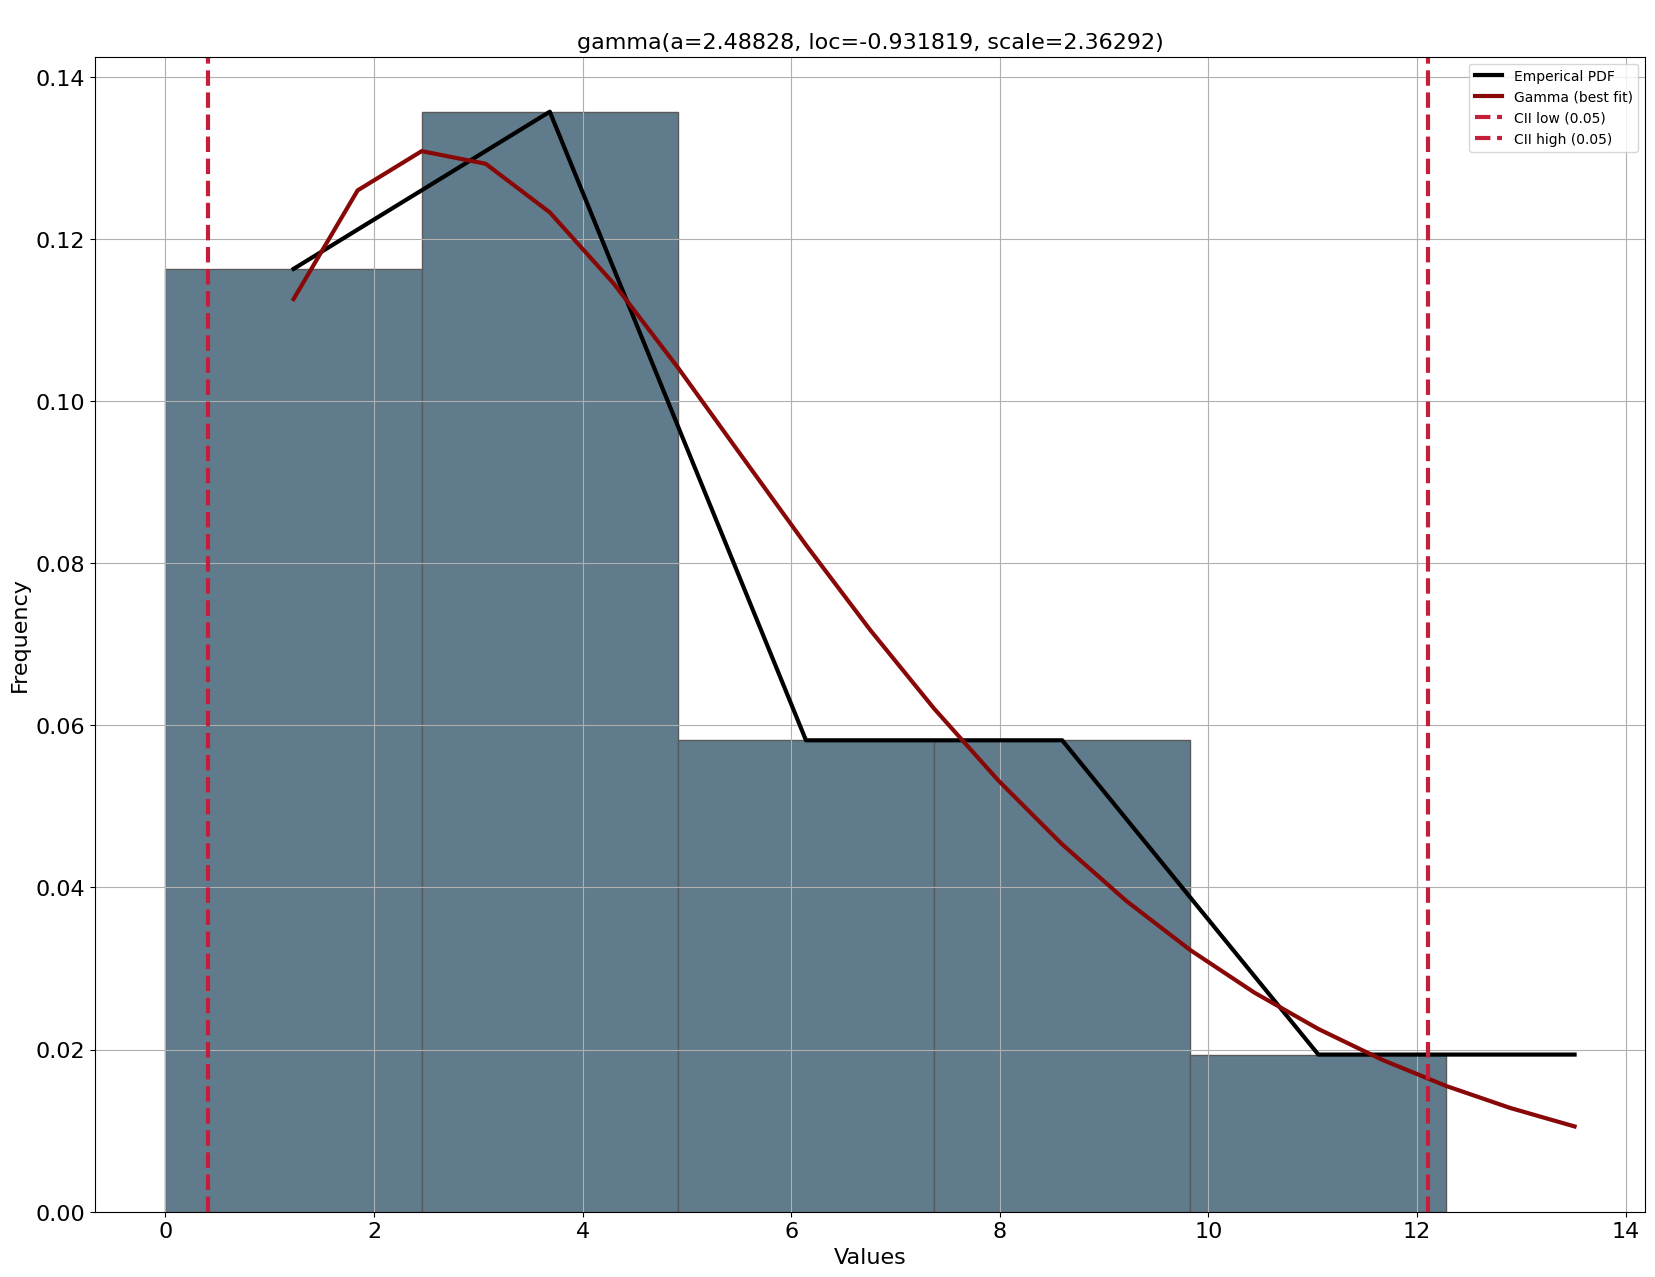

In [61]:
key = 2140
country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
min_year = int(country_lnmrdf['Year'].min())
max_year = int(country_lnmrdf['Year'].max())
ma = country_lnmrdf[country_lnmrdf['Year'] > min_year].drop(columns=['Country', 'Year']).values
mb = country_lnmrdf[country_lnmrdf['Year'] < max_year].drop(columns=['Country', 'Year']).values

m = np.nan_to_num(ma - mb)
scaler = preprocessing.StandardScaler().fit(m)
m_scaled = np.nan_to_num(scaler.transform(m))
u, singular, V_transpose = np.linalg.svd(m_scaled)
dist = distfit()
# gamma distribution 
dist.fit_transform(singular)
display(dist.summary)
dist.plot()

In [28]:
# fit the model 
# construct the matrix M, of log mortalit rate changes, second year to last year
# time span will be 5 years, since the age group is divided in 5 
done = False
pred_year = 5
each_country_num = 300
if not done:
    
    country_list = list(set(lnmrdf['Country']))
    country_list.sort()
    mort_d = {}
    
    for key in country_list:
        
        display(key)
        c_s = {}
        
        country_lnmrdf = lnmrdf[lnmrdf['Country'] == key]
        min_year = int(country_lnmrdf['Year'].min())
        max_year = int(country_lnmrdf['Year'].max())
        
        ma = country_lnmrdf[country_lnmrdf['Year'] > min_year].drop(columns=['Country', 'Year']).values
        mb = country_lnmrdf[country_lnmrdf['Year'] < max_year].drop(columns=['Country', 'Year']).values

        m = np.nan_to_num(ma - mb)
        scaler = preprocessing.StandardScaler().fit(m)
        m_scaled = np.nan_to_num(scaler.transform(m))
        u, singular, V_transpose = np.linalg.svd(m_scaled)
        dist = distfit()
        # gamma distribution 
        dist.fit_transform(singular)
        # loading vectors
        pca = PCA(n_components=1)
        transformed_data = pca.fit(m_scaled).transform(m_scaled)
        eigenValues = pca.explained_variance_ratio_
        # loading = pca.components_.T * np.sqrt(pca.explained_variance_)
        loadings = pd.DataFrame(pca.components_.T)
        lv = np.matrix(loadings[0].values)
        
        for i in range (each_country_num):    
            m_new = np.matrix(dist.generate(pred_year)).reshape(pred_year, 1)
            pred = m_new * lv
            c_s.add(pred)
            
        mort_d[key] = c_s
    
    
                
                

        

0.02857142857142857

2140

1961

TypeError: 'list' object is not callable